In [ ]:
# imports
import sys
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
import keras
from matplotlib.pyplot import figure
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# read data
raw_data = pd.read_csv('Epileptic_Seizure_Recognition.csv', header=None)

<ipython-input-2-1fc27e14f99b>:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('Epileptic_Seizure_Recognition.csv', header=None)


In [ ]:
raw_data.shape

(11501, 180)

In [ ]:
raw_data

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
1,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
2,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
3,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
4,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11496,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11497,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11498,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11499,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [ ]:
data = raw_data.values
data = data[1:11501, 1:180]
#data[:, 178] = data[:, 178].astype(int)
data.shape

(11500, 179)

In [ ]:
type(data)

numpy.ndarray

In [ ]:
# Classifying data categories
# Data source: https://www.kaggle.com/harunshimanto/epileptic-seizure-recognition

D = data
df_1 = D[D[:, 178]==1]
df_2 = D[D[:, 178]==2]
df_3 = D[D[:, 178]==3]
df_4 = D[D[:, 178]==4]
df_5 = D[D[:, 178]==5]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_3 = df_3.astype(int)
df_4 = df_4.astype(int)
df_5 = df_5.astype(int)

(1488, 179)
(1497, 179)
(1462, 179)
(1450, 179)
(1508, 179)


In [ ]:
"""### Experiment 1: Comparing CNN and BiLSTM on Epilepsy versus Healthy Data Categories"""

df_3[:, 178] = df_3[:, 178] - 3
D1 = np.concatenate([df_1, df_3])

# Creating training (80), validation (10) and test (10) data from category 1 and 3
number_of_rows = D1.shape[0]

random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.8), replace=False)

label_train = D1[random_indices, -1]
data_train = D1[random_indices, :-1]

D1_rest = np.delete(D1, random_indices, 0)

number_of_rows = D1_rest.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.5), replace=False)

label_val = D1_rest[random_indices, -1]
data_val = D1_rest[random_indices, :-1]

D1_rest_rest = np.delete(D1_rest, random_indices, 0)
label_test = D1_rest_rest[:, -1]
data_test = D1_rest_rest[:, :-1]

data_train = np.expand_dims(data_train, axis=2)
data_val = np.expand_dims(data_val, axis=2)
data_test = np.expand_dims(data_test, axis=2)

print(label_train.shape, data_train.shape)
print(label_val.shape, data_val.shape)
print(label_test.shape, data_test.shape)

(2360,) (2360, 178, 1)
(295,) (295, 178, 1)
(295,) (295, 178, 1)


In [ ]:
# Define model evaluation function
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1','2', '3']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [ ]:
# Define CNN network
def network_CNN(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')

    conv1d_1 = layers.Conv1D(filters=32, kernel_size=6)(inputs_cnn)
    batch_normalization = BatchNormalization()(conv1d_1)
    max_pooling1d = layers.MaxPooling1D( 2, padding='same')(batch_normalization)

    conv1d_2 = layers.Conv1D(filters=64, kernel_size=3)(max_pooling1d)
    batch_normalization_1 = BatchNormalization()(conv1d_2)
    max_pooling1d_1 = layers.MaxPooling1D(2, padding='same')(batch_normalization_1)

    flatten = Flatten()(max_pooling1d_1)

    dense = Dense(32)(flatten)
    dense_1 = Dense(16)(dense)

    main_output = Dense(2)(dense_1)

    model1 = Model(inputs= inputs_cnn, outputs=main_output)
    model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model1)

In [ ]:
from tensorflow import keras

# Define CNN model to be trained on epileptic vs healthy data
model1 = network_CNN(data_train, label_train)
print(model1.summary())

# Define the path where the model weights will be saved
save_path = '/tmp/checkpoint_1.weights.h5'

# Define the ModelCheckpoint callback
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs_cnn (InputLayer)              │ (None, 178, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 173, 32)             │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 173, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 87, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 85, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 85, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          88,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,474 (372.95 KB)

 Trainable params: 95,282 (372.20 KB)

 Non-trainable params: 192 (768.00 B)

None


In [ ]:
history = model1.fit(data_train, label_train,epochs=50, batch_size=32, validation_data=(data_val,label_val), callbacks=[model_checkpoint_callback])

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.7041 - loss: 1.7426 - val_accuracy: 0.5627 - val_loss: 2.1580
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7941 - loss: 0.8704 - val_accuracy: 0.7797 - val_loss: 0.8628
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8734 - loss: 0.6576 - val_accuracy: 0.8610 - val_loss: 0.7560
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9223 - loss: 0.5599 - val_accuracy: 0.9017 - val_loss: 0.5769
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9181 - loss: 0.5563 - val_accuracy: 0.9356 - val_loss: 0.3371
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9300 - loss: 0.4919 - val_accuracy: 0.9356 - val_loss: 0.3197
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9343 - loss: 0.5042 - val_accuracy: 0.9525 - val_loss: 0.1731
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9447 - loss: 0.4679 - val_accuracy: 0.9390 - 

Accuracy: 52.54%


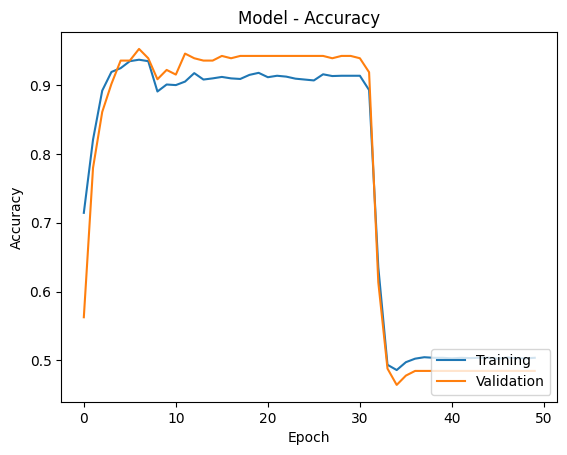

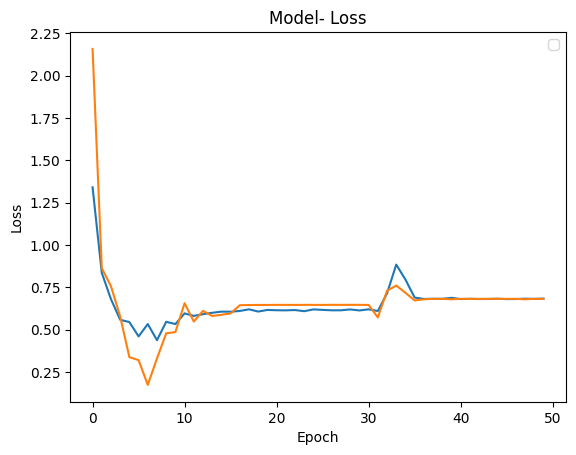

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss
evaluate_model(history,data_test,label_test,model1)
y_pred=model1.predict(data_test)

Accuracy: 95.25%


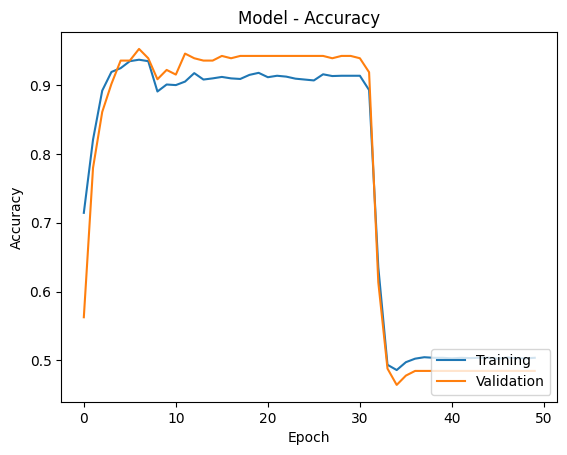

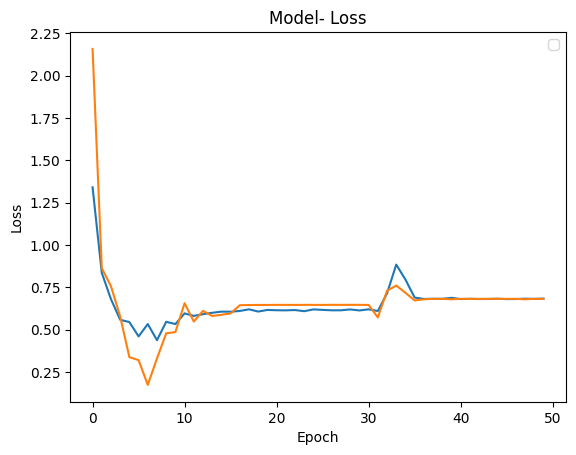

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss for the model's best version
model1.load_weights(save_path)
evaluate_model(history,data_test,label_test,model1)

In [ ]:
# Define Bidirectional LSTM model
def network_LSTM(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_lstm=Input(shape=(im_shape), name='inputs_lstm')

    dense = Dense(units=32, activation='relu', name='dense')(inputs_lstm)
    lstm = layers.Bidirectional(LSTM(units=128, name='lstm'))(dense)
    dropout = Dropout(0.3)(lstm)
    batch_normalization = BatchNormalization(name='batch_normalization')(dropout)
    dense_1 = Dense(units=64, activation='relu', name='dense_1')(batch_normalization)
    dropout_2 = Dropout(0.3, name='dropout_2')(dense_1)
    batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(dropout_2)
    main_output = Dense(units=2, activation='softmax')(batch_normalization_1)

    model = Model(inputs= inputs_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model)

In [ ]:
# Define your BiLSTM model (Ensure this function is correctly implemented)
model2 = network_LSTM(data_train, label_train)
print(model2.summary())

# Define the path where the model weights will be saved
save_path = '/tmp/checkpoint_2.weights.h5'

# Define the ModelCheckpoint callback
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs_lstm (InputLayer)             │ (None, 178, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 178, 32)             │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 182,786 (714.01 KB)

 Trainable params: 182,146 (711.51 KB)

 Non-trainable params: 640 (2.50 KB)

None


In [ ]:
history2 = model2.fit(data_train, label_train,epochs=50, batch_size=32, validation_data=(data_val,label_val), callbacks=[model_checkpoint_callback])

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 468ms/step - accuracy: 0.8382 - loss: 0.3791 - val_accuracy: 0.9492 - val_loss: 0.1657
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - accuracy: 0.9335 - loss: 0.1664 - val_accuracy: 0.8915 - val_loss: 0.2522
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - accuracy: 0.9575 - loss: 0.1137 - val_accuracy: 0.9424 - val_loss: 0.1617
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 35s 480ms/step - accuracy: 0.9574 - loss: 0.1257 - val_accuracy: 0.9153 - val_loss: 0.2468
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - accuracy: 0.9420 - loss: 0.1411 - val_accuracy: 0.9729 - val_loss: 0.0680
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.9547 - loss: 0.1257 - val_accuracy: 0.9593 - val_loss: 0.1199
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 452ms/step - accuracy: 0.9444 - loss: 0.1451 - val_accuracy: 0.9627 - val_loss: 0.0995
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 449ms/step - accuracy: 0.9618 - loss: 0.1126 - val_accu

Accuracy: 96.95%


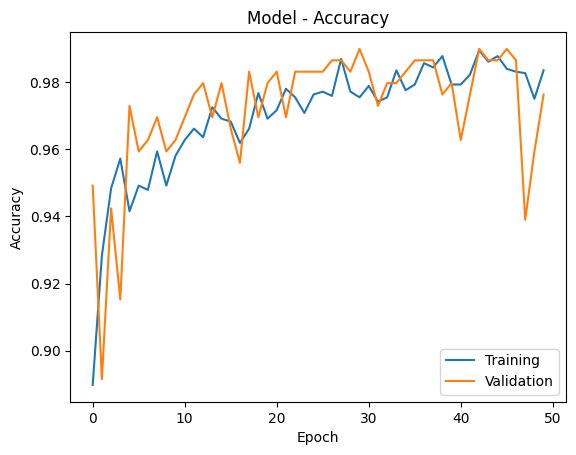

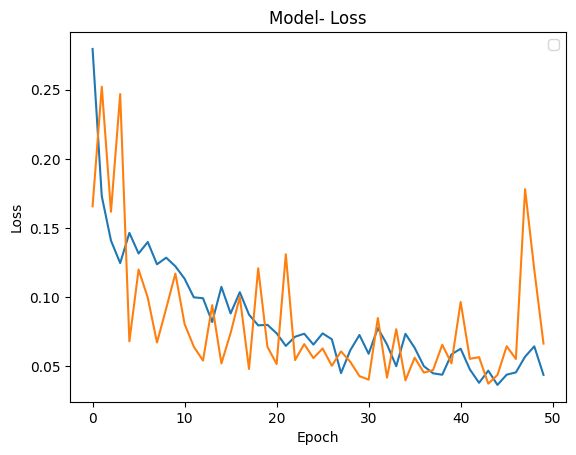

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss
evaluate_model(history2,data_test,label_test,model2)

Accuracy: 94.92%


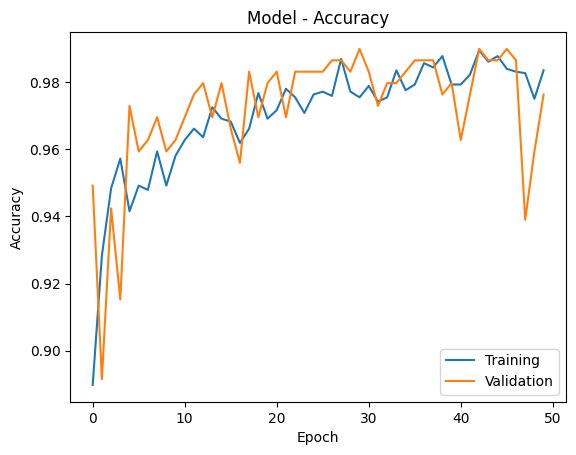

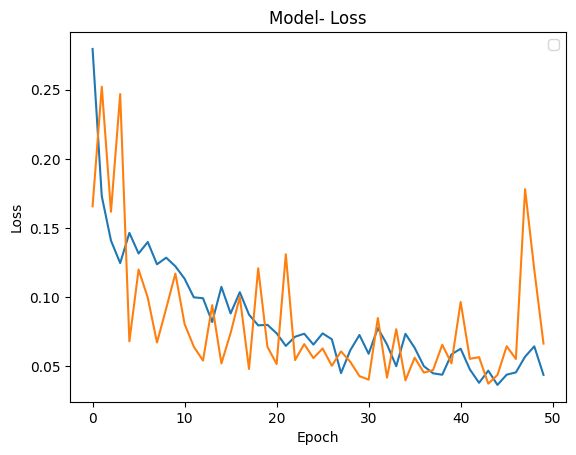

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss for the model's best version
model2.load_weights(save_path)
evaluate_model(history2,data_test,label_test,model2)

In [ ]:
"""### Experiment 2: Comparing CNN and BiLSTM on Epilepsy versus All Other Data Categories"""

# Define data categories
D = data
df_1 = D[D[:, 178]==1]
df_2 = D[D[:, 178]==2]
df_3 = D[D[:, 178]==3]
df_4 = D[D[:, 178]==4]
df_5 = D[D[:, 178]==5]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(1488, 179)
(1497, 179)
(1462, 179)
(1450, 179)
(1508, 179)


In [ ]:
df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_3 = df_3.astype(int)
df_4 = df_4.astype(int)
df_5 = df_5.astype(int)

In [ ]:
# Concatenate 4 categories into 1 data set
df_2[:, 178] = df_2[:, 178] - 2
df_3[:, 178] = df_3[:, 178] - 3
df_4[:, 178] = df_4[:, 178] - 4
df_5[:, 178] = df_5[:, 178] - 5

D2 = np.concatenate([df_1, df_2, df_3, df_4, df_5])

In [ ]:
# Creating training (80), validation (10) and test (10) data from category 1 and the remaining 4 concatenated
number_of_rows = D2.shape[0]

random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.8), replace=False)

label_train_all = D2[random_indices, -1]
data_train_all = D2[random_indices, :-1]

D2_rest = np.delete(D2, random_indices, 0)

number_of_rows = D2_rest.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.5), replace=False)

label_val_all = D2_rest[random_indices, -1]
data_val_all = D2_rest[random_indices, :-1]

D2_rest_rest = np.delete(D2_rest, random_indices, 0)
label_test_all = D2_rest_rest[:, -1]
data_test_all = D2_rest_rest[:, :-1]

data_train_all = np.expand_dims(data_train_all, axis=2)
data_val_all = np.expand_dims(data_val_all, axis=2)
data_test_all = np.expand_dims(data_test_all, axis=2)

print(label_train_all.shape, data_train_all.shape)
print(label_val_all.shape, data_val_all.shape)
print(label_test_all.shape, data_test_all.shape)

(5924,) (5924, 178, 1)
(740,) (740, 178, 1)
(741,) (741, 178, 1)


In [ ]:
# Define CNN model to be trained on epileptic vs all data
model3 = network_CNN(data_train_all, label_train_all)
print(model3.summary())

# Define the path where the model weights will be saved
save_path = '/tmp/checkpoint_3.weights.h5'

# Define the ModelCheckpoint callback
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs_cnn (InputLayer)              │ (None, 178, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 173, 32)             │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 173, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 87, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 85, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 85, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │          88,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,474 (372.95 KB)

 Trainable params: 95,282 (372.20 KB)

 Non-trainable params: 192 (768.00 B)

None


In [ ]:
history3 = model3.fit(data_train_all, label_train_all,epochs= 50, batch_size=32, validation_data=(data_val_all,label_val_all), callbacks=[model_checkpoint_callback])

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7756 - loss: 2.2634 - val_accuracy: 0.7176 - val_loss: 1.0250
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7626 - loss: 1.1062 - val_accuracy: 0.8324 - val_loss: 1.1343
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8458 - loss: 0.8999 - val_accuracy: 0.8622 - val_loss: 0.7471
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8574 - loss: 0.7254 - val_accuracy: 0.8743 - val_loss: 0.7189
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7961 - loss: 0.7738 - val_accuracy: 0.6270 - val_loss: 0.7660
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5102 - loss: 0.8157 - val_accuracy: 0.3581 - val_loss: 0.7775
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3210 - loss: 0.7960 - val_accuracy: 0.3446 - val_loss: 0.8299
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3323 - loss: 0.7969 - val_accu

Accuracy: 61.27%


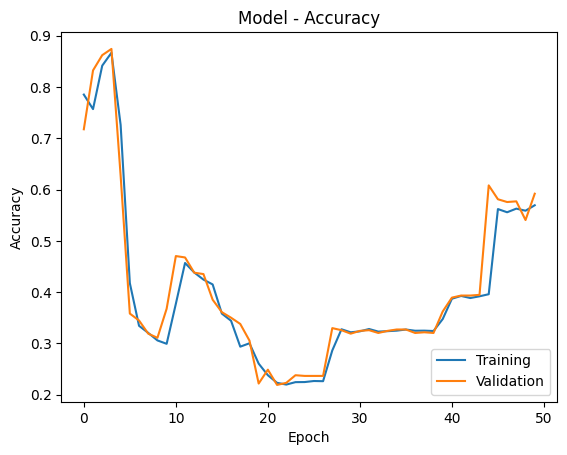

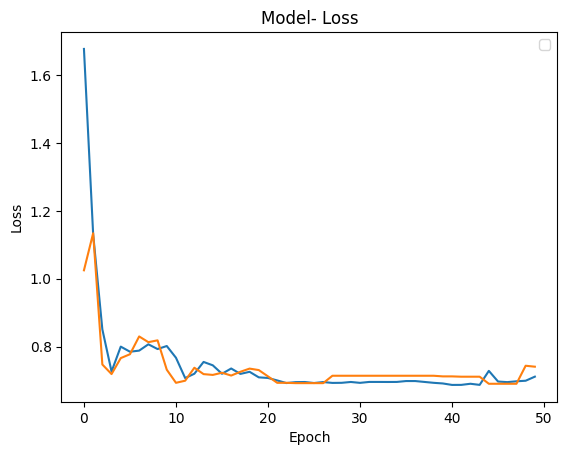

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss
evaluate_model(history3, data_test_all, label_test_all, model3)

Accuracy: 86.50%


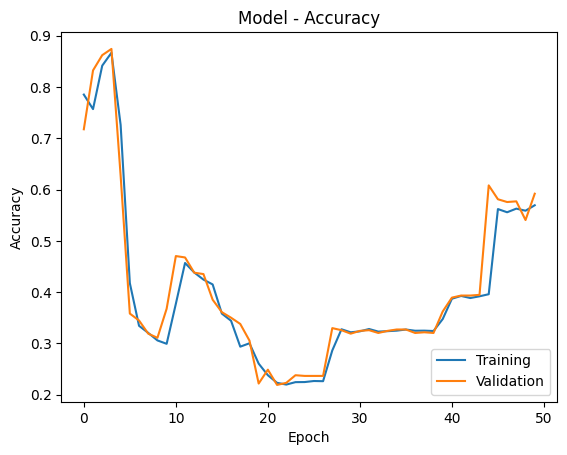

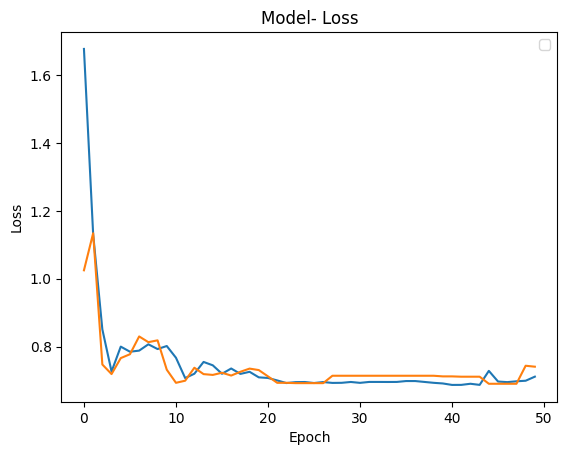

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss for the model's best version
model3.load_weights(save_path)
evaluate_model(history3, data_test_all, label_test_all, model3)

In [ ]:
# Define BiLSTM model to be trained on epileptic vs all data
model4 = network_LSTM(data_train_all, label_train_all)
print(model4.summary())

# Define the path where the model weights will be saved
save_path = '/tmp/checkpoint_4.weights.h5'

# Define the ModelCheckpoint callback
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs_lstm (InputLayer)             │ (None, 178, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 178, 32)             │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 182,786 (714.01 KB)

 Trainable params: 182,146 (711.51 KB)

 Non-trainable params: 640 (2.50 KB)

None


In [ ]:
history4 = model4.fit(data_train_all, label_train_all,epochs= 50, batch_size=32, validation_data=(data_val_all,label_val_all), callbacks=[model_checkpoint_callback])

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 85s 420ms/step - accuracy: 0.7886 - loss: 0.4725 - val_accuracy: 0.9378 - val_loss: 0.1805
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 78s 420ms/step - accuracy: 0.9223 - loss: 0.2095 - val_accuracy: 0.9486 - val_loss: 0.1398
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 79s 421ms/step - accuracy: 0.9394 - loss: 0.1825 - val_accuracy: 0.9189 - val_loss: 0.2640
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 77s 414ms/step - accuracy: 0.9362 - loss: 0.1861 - val_accuracy: 0.9500 - val_loss: 0.1396
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 83s 417ms/step - accuracy: 0.9447 - loss: 0.1571 - val_accuracy: 0.9541 - val_loss: 0.1331
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 81s 413ms/step - accuracy: 0.9513 - loss: 0.1332 - val_accuracy: 0.9662 - val_loss: 0.1101
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 84s 427ms/step - accuracy: 0.9556 - loss: 0.1352 - val_accuracy: 0.9378 - val_loss: 0.1650
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 79s 409ms/step - accuracy: 0.9493 - loss: 0

In [ ]:
# Print validation accuracy and plot accuracy and loss
evaluate_model(history4, data_test_all, label_test_all, model4)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step


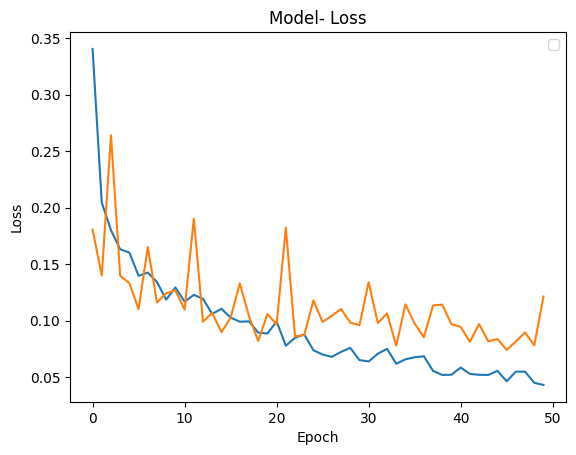

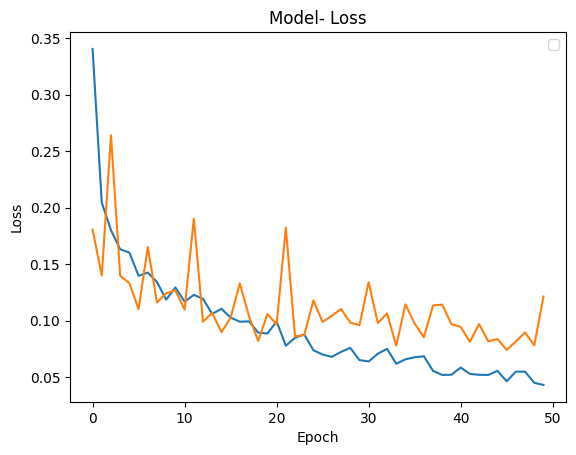

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step


In [ ]:
# Print validation accuracy and plot accuracy and loss for the model's best version
model4.load_weights(save_path)
evaluate_model(history4, data_test_all, label_test_all, model4)

Model: "functional_4"

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs_tcn (InputLayer)              │ (None, 178, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 178, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs_tcn (InputLayer)              │ (None, 178, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 178, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,266 (122.13 KB)

 Total params: 31,266 (122.13 KB)

 Trainable params: 31,266 (122.13 KB)

 Trainable params: 31,266 (122.13 KB)

 Non-trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
None
Epoch 1/50
Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6718 - loss: 1.1565 - val_accuracy: 0.8678 - val_loss: 0.2854
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6718 - loss: 1.1565 - val_accuracy: 0.8678 - val_loss: 0.2854
Epoch 2/50
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8887 - loss: 0.2963 - val_accuracy: 0.9153 - val_loss: 0.2582
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8887 - loss: 0.2963 - val_accuracy: 0.9153 - val_loss: 0.2582
Epoch 3/50
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8958 - loss: 0.2636 - val_accuracy: 0.9559 - val_loss: 0.1253
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8958 - loss: 0.2636 - val_accuracy: 0.9559 - val_loss: 0.1253
Epoch 4/50
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9278 - loss: 0.1960 - val_accuracy: 0.9458 - val_loss: 0.1940
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9278 - loss: 0.1960 - val_accuracy: 

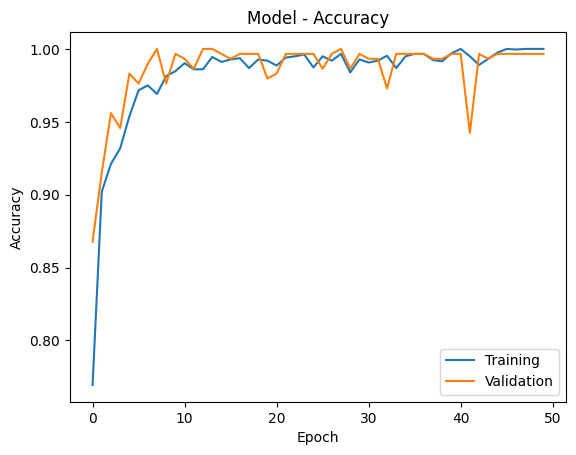

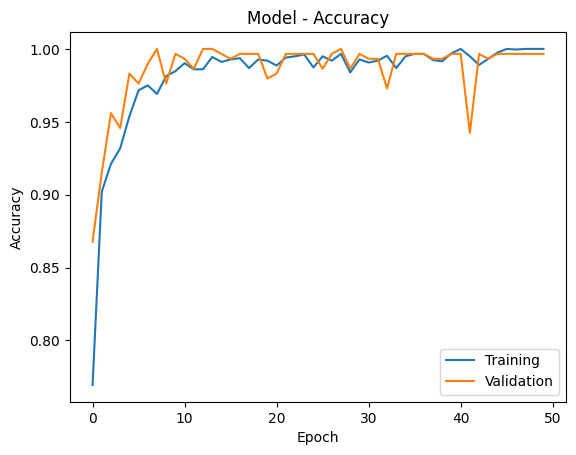

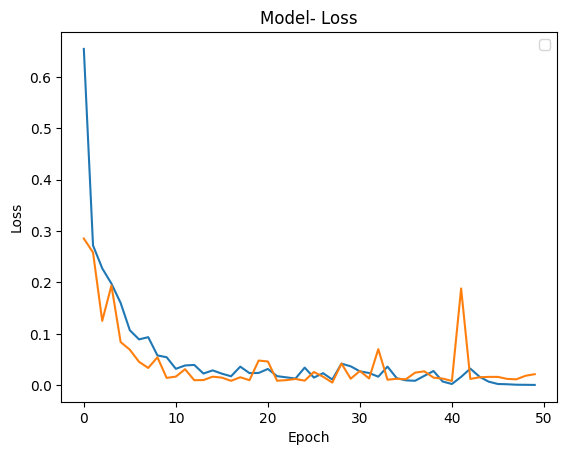

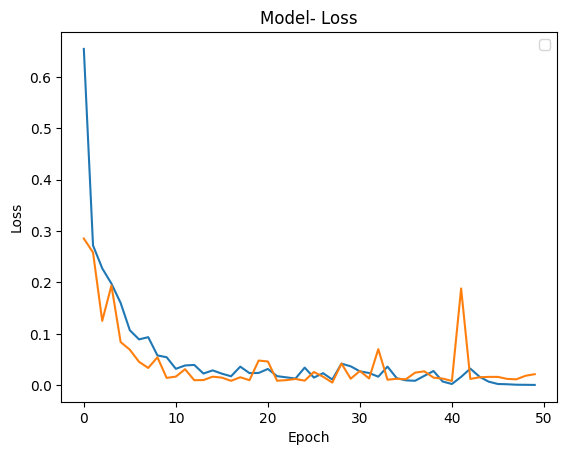

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Model: "functional_5"

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs_tcn (InputLayer)              │ (None, 178, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 178, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs_tcn (InputLayer)              │ (None, 178, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 178, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,266 (122.13 KB)

 Total params: 31,266 (122.13 KB)

 Trainable params: 31,266 (122.13 KB)

 Trainable params: 31,266 (122.13 KB)

 Non-trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
None
Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.6520 - loss: 1.2873 - val_accuracy: 0.9095 - val_loss: 0.3724
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.6520 - loss: 1.2873 - val_accuracy: 0.9095 - val_loss: 0.3724
Epoch 2/50
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9169 - loss: 0.3094 - val_accuracy: 0.9324 - val_loss: 0.2130
186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9169 - loss: 0.3094 - val_accuracy: 0.9324 - val_loss: 0.2130
Epoch 3/50
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9491 - loss: 0.1619 - val_accuracy: 0.9568 - val_loss: 0.1481
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9491 - loss: 0.1619 - val_accuracy: 0.9568 - val_loss: 0.1481
Epoch 4/50
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9669 - loss: 0.0982 - val_accuracy: 0.9608 - val_loss: 0.1230
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9669 - loss: 0.098

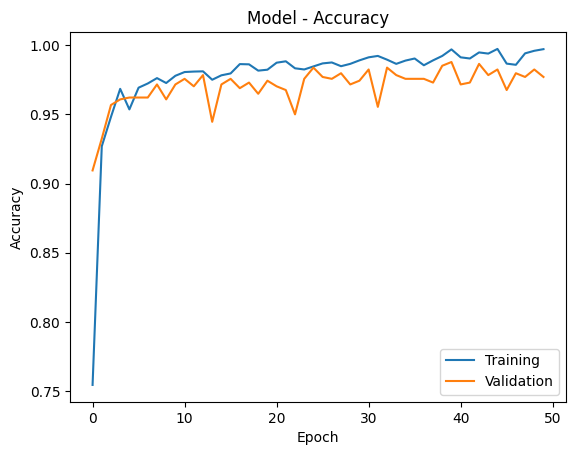

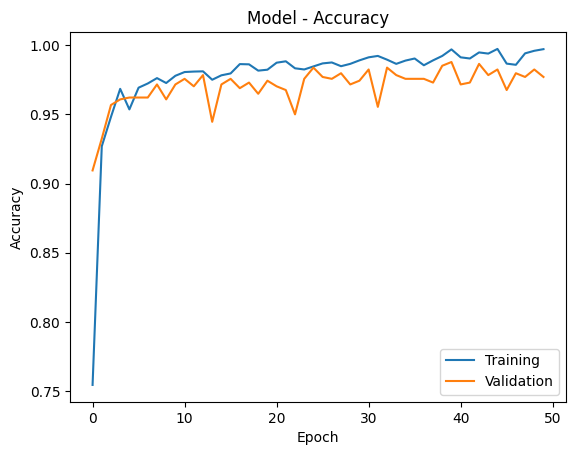

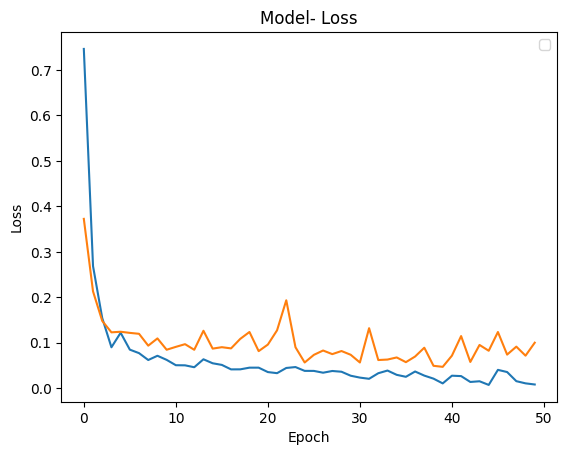

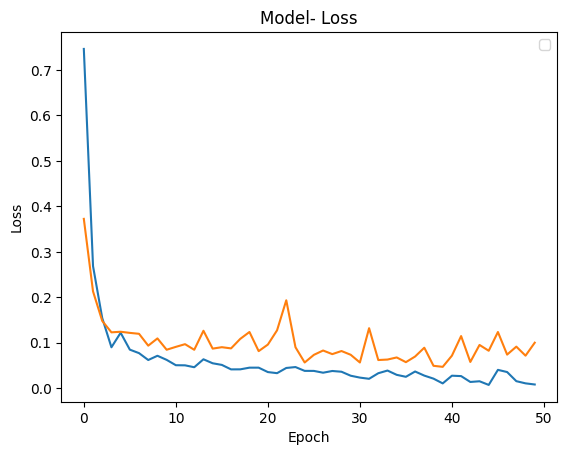

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def network_TCN(X_train, y_train):
    # Define input layer
    inputs_tcn = layers.Input(shape=(X_train.shape[1], X_train.shape[2]), name='inputs_tcn')

    # Temporal convolutional layers
    tcn1 = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs_tcn)
    tcn2 = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(tcn1)
    tcn3 = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(tcn2)

    # Global max pooling layer
    pool1 = layers.GlobalMaxPooling1D()(tcn3)

    # Dense layers
    dense1 = layers.Dense(64, activation='relu')(pool1)
    dense2 = layers.Dense(32, activation='relu')(dense1)

    # Output layer
    main_output = layers.Dense(2, activation='softmax')(dense2)

    # Define and compile model
    model = tf.keras.Model(inputs=inputs_tcn, outputs=main_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Use the function to create the TCN model for Epilepsy versus Healthy Data Categories
model6_1 = network_TCN(data_train, label_train)
print(model6_1.summary())

# Train the TCN model for Epilepsy versus Healthy Data Categories
history6_1 = model6_1.fit(data_train, label_train, epochs=50, batch_size=32, validation_data=(data_val, label_val))

# Evaluate the TCN model for Epilepsy versus Healthy Data Categories
print("Evaluation for Epilepsy versus Healthy Data Categories:")
evaluate_model(history6_1, data_test, label_test, model6_1)

# Define TCN model to be trained on Epilepsy versus All Other Data Categories
model6_2 = network_TCN(data_train_all, label_train_all)
print(model6_2.summary())

# Train the TCN model for Epilepsy versus All Other Data Categories
history6_2 = model6_2.fit(data_train_all, label_train_all, epochs=50, batch_size=32, validation_data=(data_val_all, label_val_all))

# Evaluate the TCN model for Epilepsy versus All Other Data Categories
print("Evaluation for Epilepsy versus All Other Data Categories:")
evaluate_model(history6_2, data_test_all, label_test_all, model6_2)

ANN Model Summary for Epilepsy versus Healthy Data Categories:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 178)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          22,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,298 (122.26 KB)

 Trainable params: 31,298 (122.26 KB)

 Non-trainable params: 0 (0.00 B)

None

Training ANN Model for Epilepsy versus Healthy Data Categories...
Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5678 - loss: 56.3304 - val_accuracy: 0.6712 - val_loss: 13.6866
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7034 - loss: 19.4579 - val_accuracy: 0.7017 - val_loss: 9.5269
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7021 - loss: 13.9122 - val_accuracy: 0.7288 - val_loss: 7.5843
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7204 - loss: 11.2570 - val_accuracy: 0.6780 - val_loss: 8.7986
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7104 - loss: 9.8142 - val_accuracy: 0.8000 - val_loss: 5.0673
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7579 - loss: 8.7603 - val_accuracy: 0.8169 - val_loss: 4.4853
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7529 - loss: 7.4726 - val_accuracy: 0.8610 - val_loss: 4.4438
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━

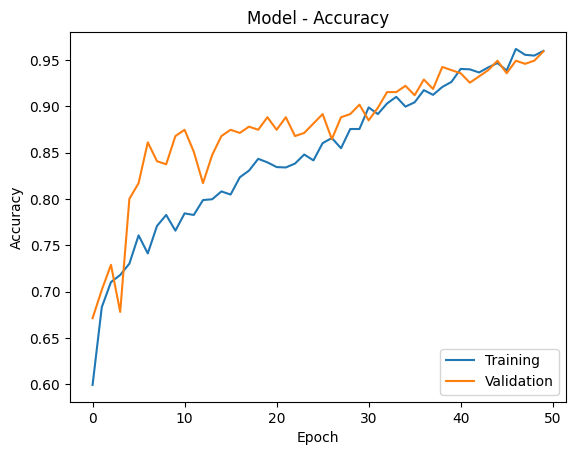

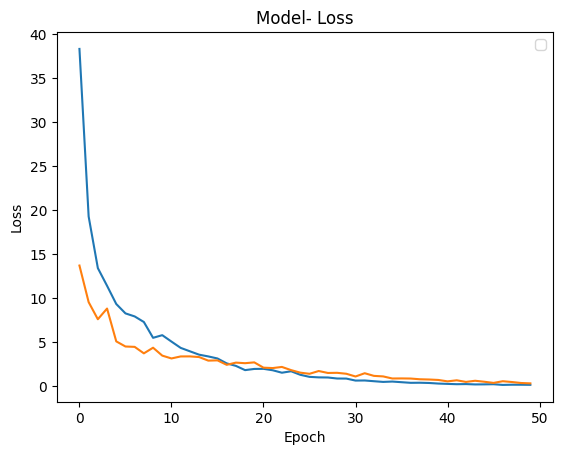

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

ANN Model Summary for Epilepsy versus All Other Data Categories:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 178)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │          22,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,298 (122.26 KB)

 Trainable params: 31,298 (122.26 KB)

 Non-trainable params: 0 (0.00 B)

None

Training ANN Model for Epilepsy versus All Other Data Categories...
Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5812 - loss: 30.4092 - val_accuracy: 0.7311 - val_loss: 6.5550
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6565 - loss: 12.2580 - val_accuracy: 0.7324 - val_loss: 5.2079
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6961 - loss: 7.9187 - val_accuracy: 0.7135 - val_loss: 3.8594
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7338 - loss: 5.0446 - val_accuracy: 0.7892 - val_loss: 2.6529
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 4.1283 - val_accuracy: 0.8351 - val_loss: 2.1074
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7646 - loss: 2.9540 - val_accuracy: 0.8338 - val_loss: 1.3738
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7822 - loss: 1.8732 - val_accuracy: 0.8473 - val_loss: 0.9874
Epoch 8/50
186/186 ━━━━━━━━━

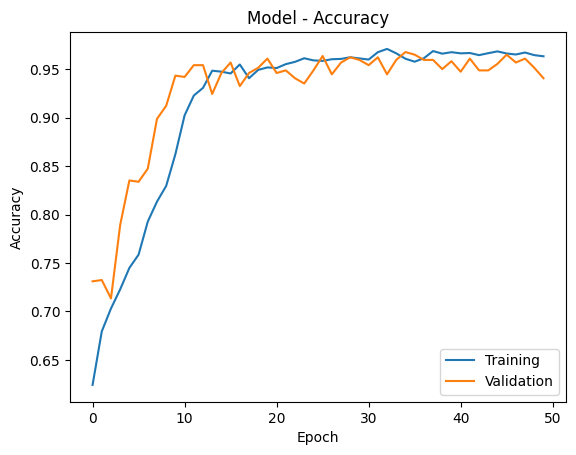

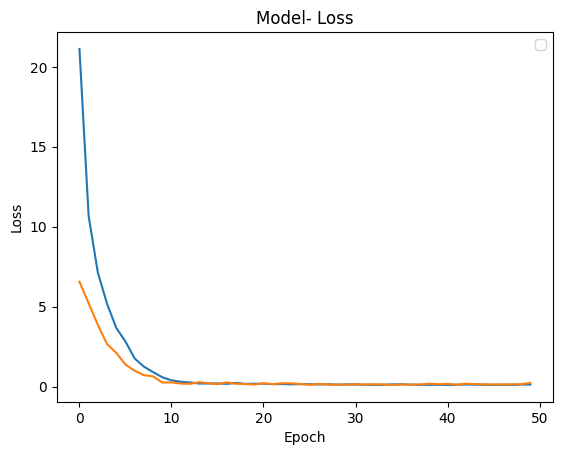

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Define ANN model function for Epilepsy versus Healthy Data Categories
def create_ann_model_epilepsy_vs_healthy(input_shape):
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create ANN model for Epilepsy versus Healthy Data Categories
ann_model_epilepsy_vs_healthy = create_ann_model_epilepsy_vs_healthy(input_shape=(data_train.shape[1], data_train.shape[2]))

# Print ANN model summary for Epilepsy versus Healthy Data Categories
print("ANN Model Summary for Epilepsy versus Healthy Data Categories:")
print(ann_model_epilepsy_vs_healthy.summary())

# Train the ANN model for Epilepsy versus Healthy Data Categories
print("\nTraining ANN Model for Epilepsy versus Healthy Data Categories...")
history_ann_epilepsy_vs_healthy = ann_model_epilepsy_vs_healthy.fit(data_train, label_train, epochs=50, batch_size=32, validation_data=(data_val, label_val))

# Evaluate the ANN model for Epilepsy versus Healthy Data Categories
print("\nEvaluating ANN Model for Epilepsy versus Healthy Data Categories...")
evaluate_model(history_ann_epilepsy_vs_healthy, data_test, label_test, ann_model_epilepsy_vs_healthy)

# Define ANN model function for Epilepsy versus All Other Data Categories
def create_ann_model_epilepsy_vs_all_other(input_shape):
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create ANN model for Epilepsy versus All Other Data Categories
ann_model_epilepsy_vs_all_other = create_ann_model_epilepsy_vs_all_other(input_shape=(data_train_all.shape[1], data_train_all.shape[2]))

# Print ANN model summary for Epilepsy versus All Other Data Categories
print("\nANN Model Summary for Epilepsy versus All Other Data Categories:")
print(ann_model_epilepsy_vs_all_other.summary())

# Train the ANN model for Epilepsy versus All Other Data Categories
print("\nTraining ANN Model for Epilepsy versus All Other Data Categories...")
history_ann_epilepsy_vs_all_other = ann_model_epilepsy_vs_all_other.fit(data_train_all, label_train_all, epochs=50, batch_size=32, validation_data=(data_val_all, label_val_all))

# Evaluate the ANN model for Epilepsy versus All Other Data Categories
print("\nEvaluating ANN Model for Epilepsy versus All Other Data Categories...")
evaluate_model(history_ann_epilepsy_vs_all_other, data_test_all, label_test_all, ann_model_epilepsy_vs_all_other)

Test Accuracies:
CNN Epileptic VS Healthy: 0.4847457706928253
CNN Epileptic VS All: 0.591891884803772
BiLSTM Epileptic VS Healthy: 0.9762712121009827
BiLSTM Epileptic VS All: 0.9702702760696411
TCN Epileptic VS Healthy: 0.996610164642334
TCN Epileptic VS All: 0.9770269989967346
ANN Epileptic VS Healthy: 0.9593220353126526
ANN Epileptic VS All: 0.9405405521392822

Best Model for Epileptic VS Healthy: TCN Epileptic VS Healthy - Accuracy: 0.996610164642334

Best Model for Epileptic VS All: TCN Epileptic VS All - Accuracy: 0.9770269989967346


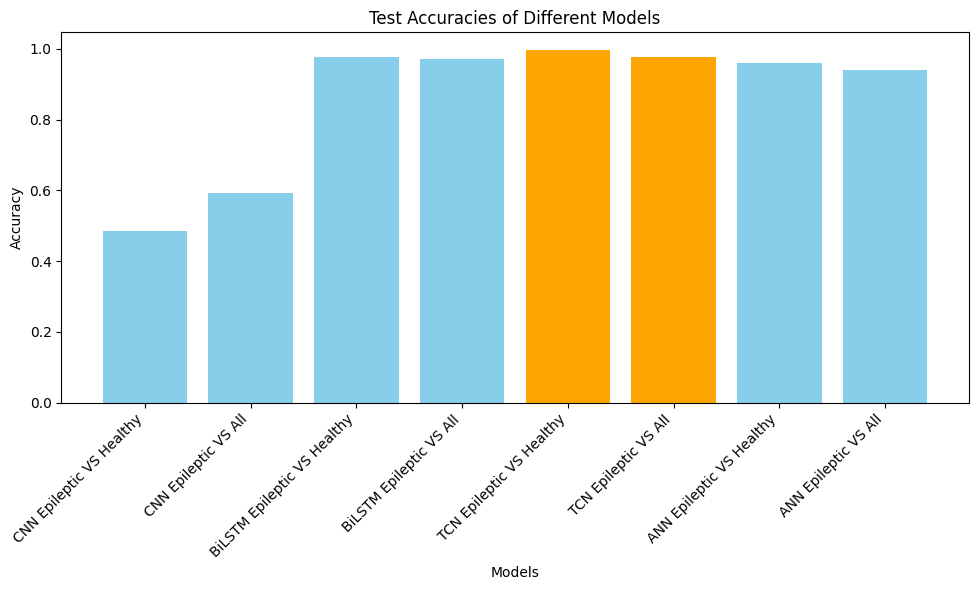

In [37]:
import matplotlib.pyplot as plt

# Extract test accuracies from history
test_accuracies = {
    "CNN Epileptic VS Healthy": history.history['val_accuracy'][-1],
    "CNN Epileptic VS All": history3.history['val_accuracy'][-1],
    "BiLSTM Epileptic VS Healthy": history2.history['val_accuracy'][-1],
    "BiLSTM Epileptic VS All": history4.history['val_accuracy'][-1],
    "TCN Epileptic VS Healthy": history6_1.history['val_accuracy'][-1],
    "TCN Epileptic VS All": history6_2.history['val_accuracy'][-1],
    "ANN Epileptic VS Healthy": history_ann_epilepsy_vs_healthy.history['val_accuracy'][-1],
    "ANN Epileptic VS All": history_ann_epilepsy_vs_all_other.history['val_accuracy'][-1]
}

# Print test accuracies
print("Test Accuracies:")
for model, accuracy in test_accuracies.items():
    print(f"{model}: {accuracy}")

# Find the best models for both comparisons
best_models = {
    "Epileptic VS Healthy": max(test_accuracies, key=lambda x: test_accuracies[x] if 'Healthy' in x else -1),
    "Epileptic VS All": max(test_accuracies, key=lambda x: test_accuracies[x] if 'All' in x else -1)
}
# Print best models
for comparison, best_model in best_models.items():
    print(f"\nBest Model for {comparison}: {best_model} - Accuracy: {test_accuracies[best_model]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.title('Test Accuracies of Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Highlighting the best models
for best_model in best_models.values():
    plt.bar(best_model, test_accuracies[best_model], color='orange')

plt.show()